/kaggle/input/start-up-founder-retention-prediction/sample_submission.csv
/kaggle/input/start-up-founder-retention-prediction/train.csv
/kaggle/input/start-up-founder-retention-prediction/test.csv
Loading data from /kaggle/input/start-up-founder-retention-prediction/train.csv and /kaggle/input/start-up-founder-retention-prediction/test.csv ...

========== Preprocessing ==========

=== Checking ordinal columns for unmapped values ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/co


Remaining NaN in TRAIN: 0
Remaining NaN in TEST : 0

========== Feature Engineering ==========

========== EDA ==========

========== BASIC INFO ==========
   founder_id  founder_age founder_gender  years_with_startup founder_role  \
0        8410         31.0           Male                19.0    Education   
1       64756         53.2         Female                 4.0        Media   
2       30257         24.0         Female                10.0   Healthcare   
3       65791         36.0         Female                 7.0    Education   
4       65026         53.2           Male                26.2    Education   

   monthly_revenue_generated  work_life_balance_rating  venture_satisfaction  \
0                     5390.0                       3.0                   1.0   
1                     5534.0                       0.0                   2.0   
2                     8159.0                       2.0                   2.0   
3                     3989.0                       2.0

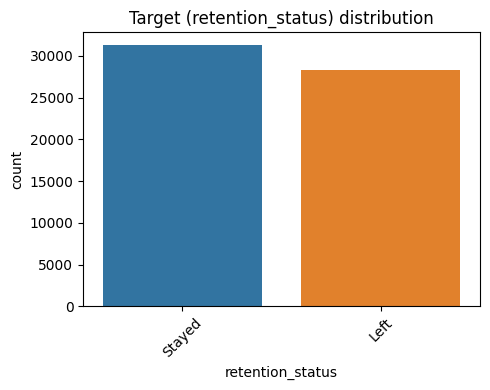

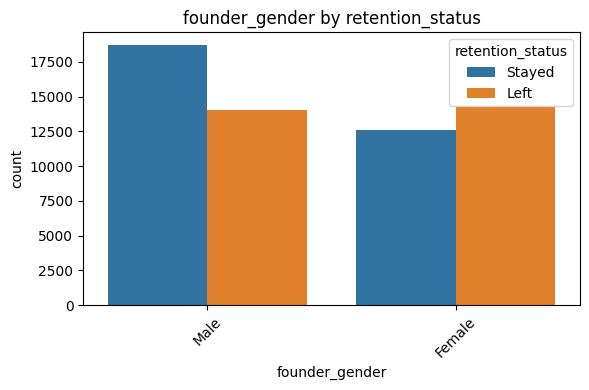

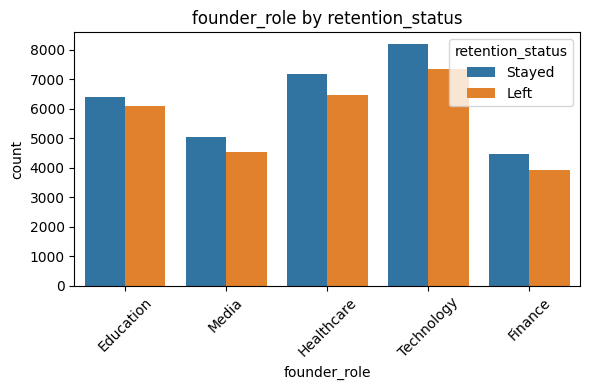

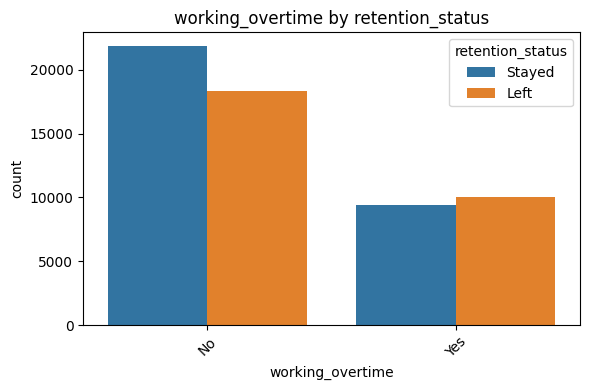

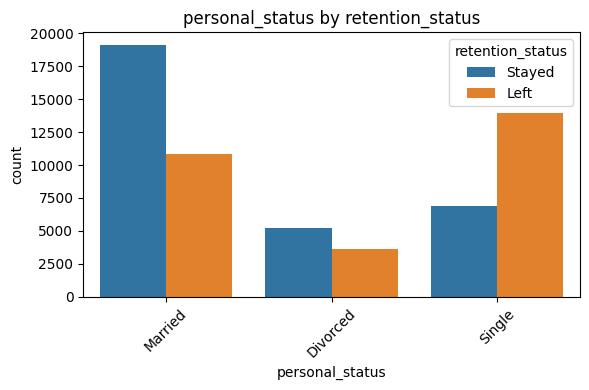

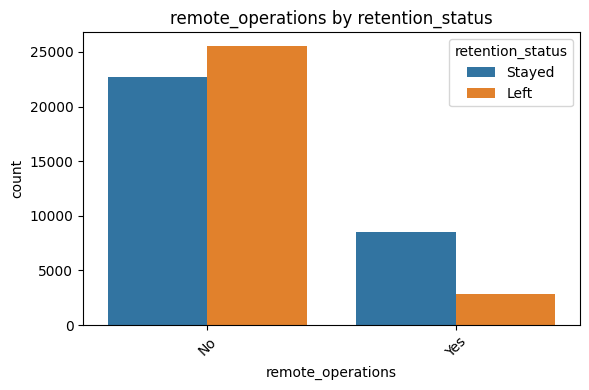

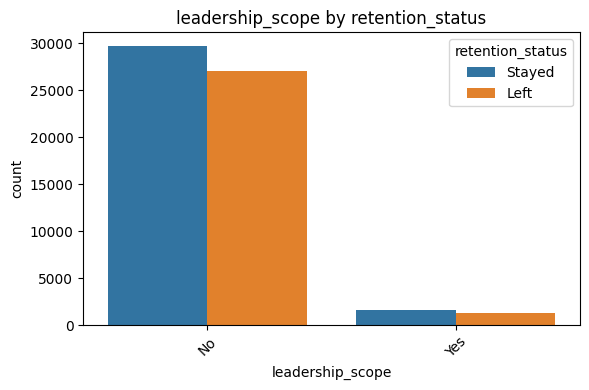

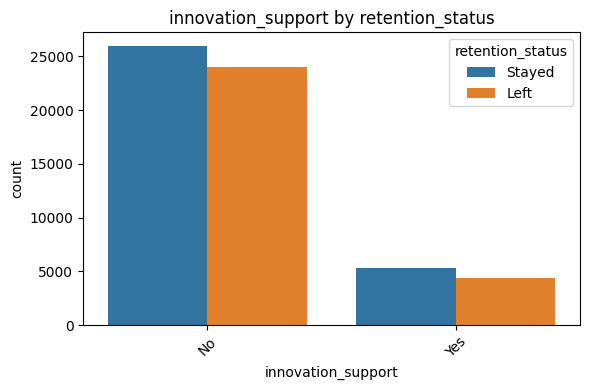

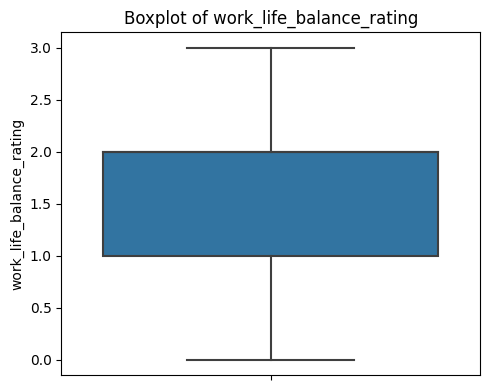

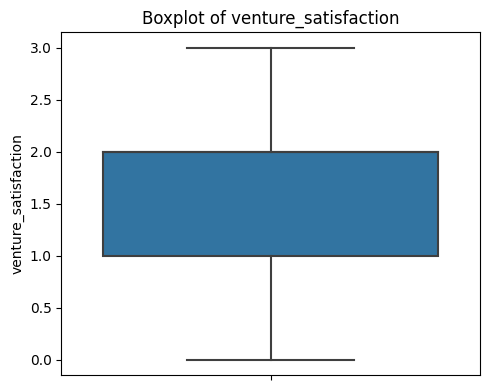

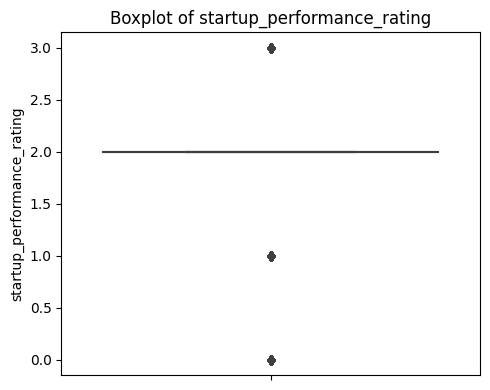

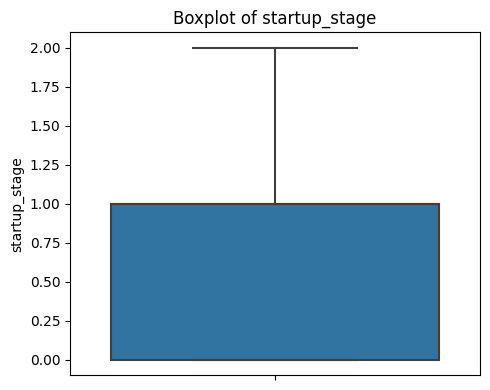

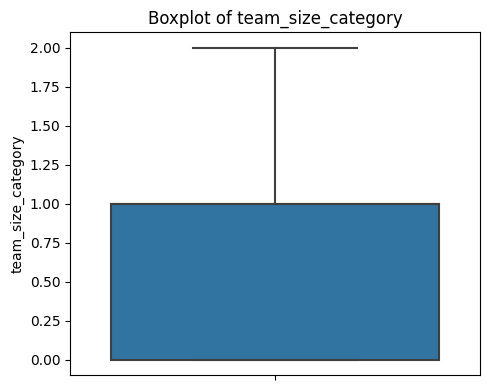

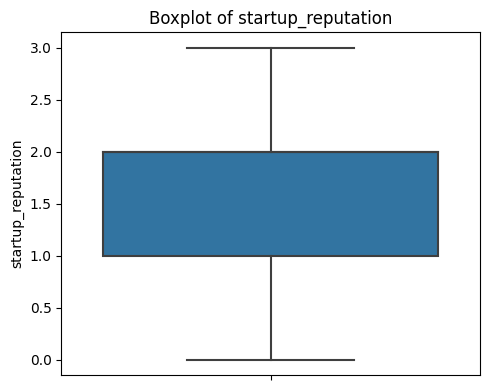

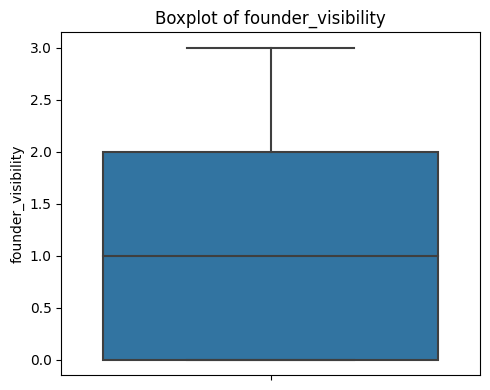

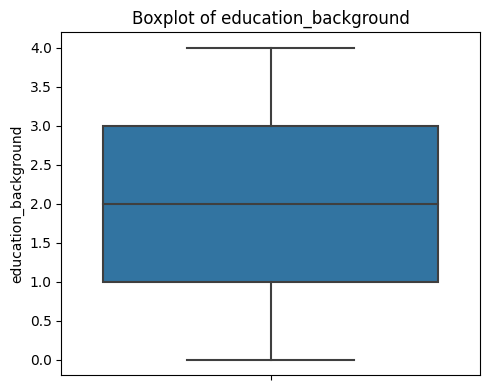

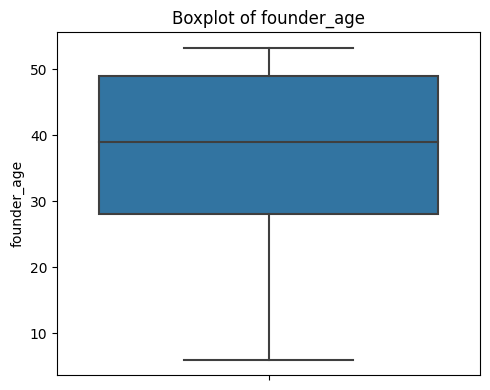

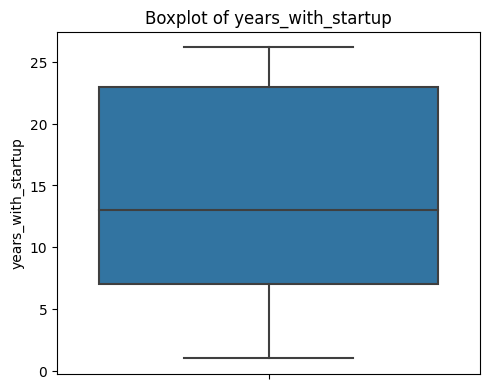

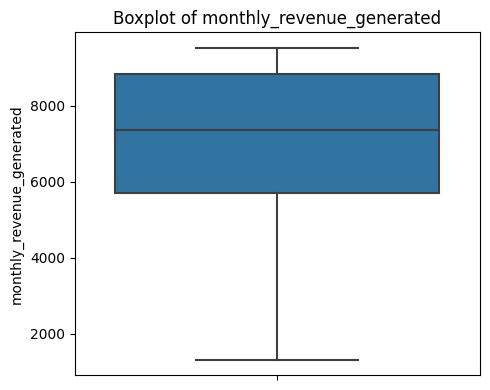

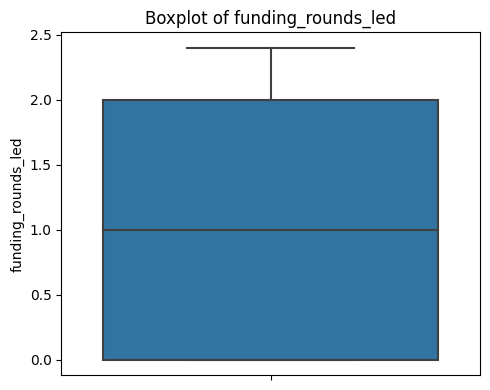

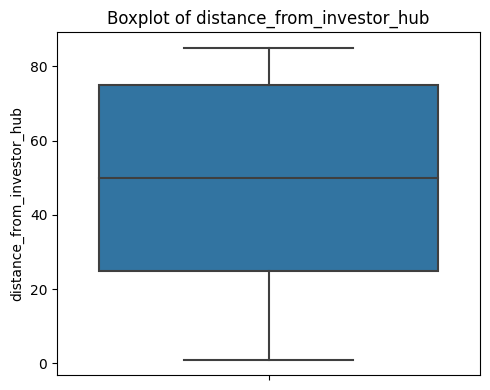

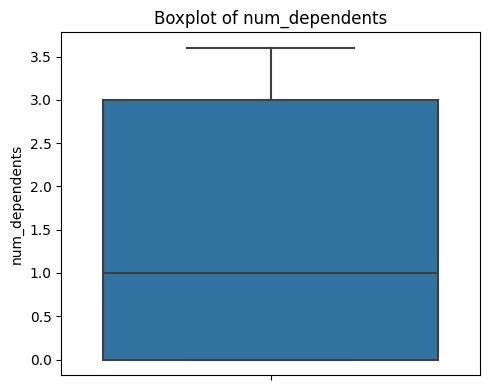

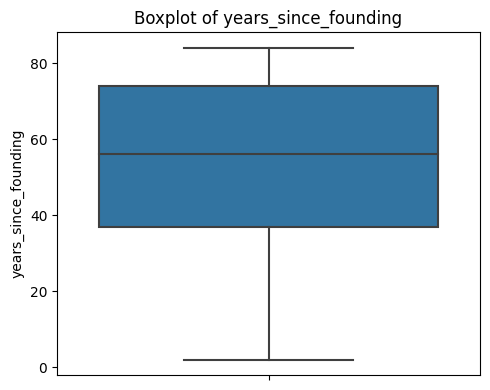

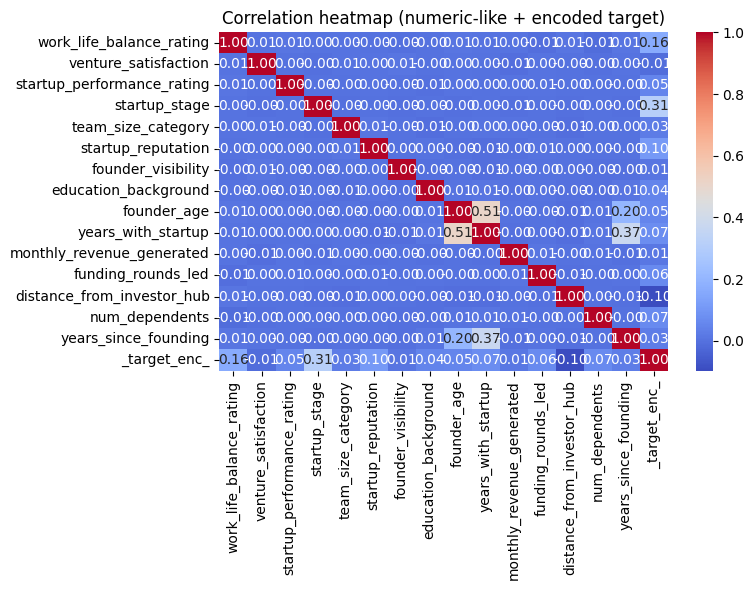


========== Mutual Information ==========
                       feature  mutual_information
10               startup_stage            0.056724
3              personal_status            0.046153
4            remote_operations            0.025992
7     work_life_balance_rating            0.016119
12          startup_reputation            0.011043
18          funding_rounds_led            0.009495
0               founder_gender            0.007630
20              num_dependents            0.007549
2             working_overtime            0.005626
14        education_background            0.005446
19  distance_from_investor_hub            0.005222
16          years_with_startup            0.003877
15                 founder_age            0.003789
5             leadership_scope            0.003728
1                 founder_role            0.003273
11          team_size_category            0.002982
8         venture_satisfaction            0.002908
13          founder_visibility          

In [5]:
# ============================================================
# 1. Libraries & basic setup
# ============================================================
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Show Kaggle input files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# ============================================================
# 2. Reproducibility
# ============================================================
def set_seed(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


# ============================================================
# 3. Feature type declarations (explicit)
# ============================================================
TARGET_COL = "retention_status"
ID_COL = "founder_id"
DROP_COLS = []  # nothing to drop by default

# Nominal (unordered categories)
NOMINAL_FEATURES = [
    "founder_gender",
    "founder_role",
    "working_overtime",
    "personal_status",
    "remote_operations",
    "leadership_scope",
    "innovation_support",
]

# Ordinal (ordered categories - we keep them numeric/int encodings)
ORDINAL_FEATURES = [
    "work_life_balance_rating",   # e.g., Low < Medium < High
    "venture_satisfaction",       # Dissatisfied < Neutral < Satisfied
    "startup_performance_rating", # Poor < Average < Excellent
    "startup_stage",              # Seed < Series A < Growth < Established
    "team_size_category",         # Small < Medium < Large
    "startup_reputation",         # Low < Moderate < High
    "founder_visibility",         # Low < Medium < High
    "education_background",
]

# Numeric (continuous / count-like)
NUMERIC_FEATURES = [
    "founder_age",
    "years_with_startup",
    "monthly_revenue_generated",
    "funding_rounds_led",
    "distance_from_investor_hub",
    "num_dependents",
    "years_since_founding",
]

ALL_FEATURES = NOMINAL_FEATURES + ORDINAL_FEATURES + NUMERIC_FEATURES


# ============================================================
# 4. Preprocessing
# ============================================================

def show_non_numeric_columns(df):
    """
    Prints all columns that contain non-numeric values,
    and shows the distinct values for each such column.
    """

    print("\n===== NON-NUMERIC COLUMNS & THEIR UNIQUE VALUES =====")

    for col in df.columns:
        # check if column contains non-numeric OR if dtype is object
        if df[col].dtype == "object":
            print(f"\nColumn: {col}")
            print(df[col].unique())
            continue

        # numeric dtype can still contain strings → check with coercion
        coerced = pd.to_numeric(df[col], errors="coerce")
        if coerced.isna().any() and df[col].isna().sum() != coerced.isna().sum():
            print(f"\nColumn: {col}")
            print(df[col].unique())

def cap_outliers_iqr(df, numeric_cols):
    """
    Caps outliers using IQR method for all numeric-like columns.
    Q1 - 1.5*IQR  → lower cap
    Q3 + 1.5*IQR  → upper cap
    """
    df = df.copy()
    for col in numeric_cols:
        if col not in df.columns:
            continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 2.1 * IQR
        upper = Q3 + 0.2 * IQR

        # Clip to limits
        df[col] = df[col].clip(lower, upper)

    return df


def preprocess_data(train_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Performs:
    - Ordinal mapping (with detection of unseen categories)
    - Median imputation for ordinal + numeric
    - Mode imputation for nominal
    - Ensures zero NaN leakage before modeling
    """

    train = train_df.copy()
    test = test_df.copy()

    train = cap_outliers_iqr(train, NUMERIC_FEATURES)
    test = cap_outliers_iqr(test, NUMERIC_FEATURES)

    # ---------------------------------------------
    # 1. Ordinal → Numeric mappings (FINAL)
    # ---------------------------------------------
    ordinal_maps = {
        "work_life_balance_rating": {
            "Poor": 0,
            "Fair": 1,
            "Good": 2,
            "Excellent": 3,
        },
        "venture_satisfaction": {
            "Low": 0,
            "Medium": 1,
            "High": 2,
            "Very High": 3,
        },
        "startup_performance_rating": {
            "Low": 0,
            "Below Average": 1,
            "Average": 2,
            "High": 3,
        },
        "startup_stage": {
            "Entry": 0,
            "Mid": 1,
            "Senior": 2,
        },
        "team_size_category": {
            "Small": 0,
            "Medium": 1,
            "Large": 2,
        },
        "startup_reputation": {
            "Poor": 0,
            "Fair": 1,
            "Good": 2,
            "Excellent": 3,
        },
        "founder_visibility": {
            "Low": 0,
            "Medium": 1,
            "High": 2,
            "Very High": 3,
        },
        "education_background": {
            "High School": 0,
            "Associate Degree": 1,
            "Bachelor’s Degree": 2,
            "Master’s Degree": 3,
            "PhD": 4,
        },
    }

    # ---------------------------------------------
    # 2. Apply mappings + report unseen categories
    # ---------------------------------------------
    print("\n=== Checking ordinal columns for unmapped values ===")
    for col, mapping in ordinal_maps.items():
        if col not in train.columns:
            continue

        # Find unseen values
        train_unmapped = set(train[col].dropna()) - set(mapping.keys())
        test_unmapped = set(test[col].dropna()) - set(mapping.keys())

        if train_unmapped:
            print(f"[TRAIN] Column '{col}' has unmapped values: {train_unmapped}")
        if test_unmapped:
            print(f"[TEST] Column '{col}' has unmapped values: {test_unmapped}")

        # Apply mapping
        train[col] = train[col].map(mapping)
        test[col] = test[col].map(mapping)

    # ---------------------------------------------
    # 3. Impute numeric-like & ordinal with median
    # ---------------------------------------------
    numeric_like_cols = ORDINAL_FEATURES + NUMERIC_FEATURES
    if numeric_like_cols:
        med = train[numeric_like_cols].median()
        train[numeric_like_cols] = train[numeric_like_cols].fillna(med)
        for col in numeric_like_cols:
            if col in test.columns:
                test[col] = test[col].fillna(med[col])

    # ---------------------------------------------
    # 4. Impute nominal with mode
    # ---------------------------------------------
    if NOMINAL_FEATURES:
        modes = train[NOMINAL_FEATURES].mode().iloc[0]
        for col in NOMINAL_FEATURES:
            train[col] = train[col].fillna(modes[col])
            if col in test.columns:
                test[col] = test[col].fillna(modes[col])

    # ---------------------------------------------
    # 5. FINAL sanity check
    # ---------------------------------------------
    remaining_train_nan = train.isna().sum().sum()
    remaining_test_nan = test.isna().sum().sum()

    print(f"\nRemaining NaN in TRAIN: {remaining_train_nan}")
    print(f"Remaining NaN in TEST : {remaining_test_nan}")

    if remaining_train_nan > 0 or remaining_test_nan > 0:
        print("\nWARNING: Some NaNs remain even after preprocessing!")

    return train, test


# ============================================================
# 5. Feature engineering
# ============================================================
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Hook for feature engineering.
    Add simple, meaningful features that help all models.
    """

    eps = 1e-6

    # Revenue per team member (approx)
    # if {"monthly_revenue_generated", "team_size_category"}.issubset(df.columns):
        # crude mapping if team_size_category encoded as categories later
        # here we just leave it for possible downstream use
        # pass

    # Revenue per year since founding
    # if {"monthly_revenue_generated", "years_since_founding"}.issubset(df.columns):
    #     df["revenue_per_year_since_founding"] = df["monthly_revenue_generated"] * 12 / (df["years_since_founding"] + 1)

    # Workload intensity: years_with_startup / years_since_founding
    # if {"years_with_startup", "years_since_founding"}.issubset(df.columns):
    #     df["workload_intensity"] = df["years_with_startup"] / (df["years_since_founding"] + 1)

    # Dependents per income (proxy stress indicator)
    # if {"num_dependents", "monthly_revenue_generated"}.issubset(df.columns):
    #     df["dependents_per_revenue"] = df["num_dependents"] / (df["monthly_revenue_generated"] + 1)

    # Remote + distance interaction
    # if {"remote_operations", "distance_from_investor_hub"}.issubset(df.columns):
    #     df["remote_distance_product"] = df["distance_from_investor_hub"] * (
    #         df["remote_operations"].astype(str).map({"Yes": 1, "No": 0}).fillna(0)
    #     )

    return df


# ============================================================
# 6. EDA helpers
# ============================================================
def run_eda(train_df: pd.DataFrame):
    print("\n========== BASIC INFO ==========")
    print(train_df.head())
    print("\nTrain shape:", train_df.shape)

    print("\nTarget distribution:")
    print(train_df[TARGET_COL].value_counts())

    # Target distribution
    plt.figure(figsize=(5, 4))
    sns.countplot(x=TARGET_COL, data=train_df)
    plt.title("Target (retention_status) distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Nominal features vs target (countplots)
    for col in NOMINAL_FEATURES:
        if col in train_df.columns:
            plt.figure(figsize=(6, 4))
            sns.countplot(x=col, hue=TARGET_COL, data=train_df)
            plt.title(f"{col} by {TARGET_COL}")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    # Numeric & ordinal: standalone boxplots
    for col in ORDINAL_FEATURES + NUMERIC_FEATURES:
        if col in train_df.columns:
            plt.figure(figsize=(5, 4))
            sns.boxplot(y=train_df[col])
            plt.title(f"Boxplot of {col}")
            plt.tight_layout()
            plt.show()

    # Correlation heatmap (numeric-like + encoded target)
    num_cols = ORDINAL_FEATURES + NUMERIC_FEATURES
    if num_cols:
        le = LabelEncoder()
        y_enc = le.fit_transform(train_df[TARGET_COL])
        corr_df = train_df[num_cols].copy()
        corr_df["_target_enc_"] = y_enc
        corr = corr_df.corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
        plt.title("Correlation heatmap (numeric-like + encoded target)")
        plt.tight_layout()
        plt.show()


# ============================================================
# 7. Mutual Information (feature importance-ish)
# ============================================================
def compute_mutual_information(df: pd.DataFrame, target_col: str, feature_cols: list) -> pd.DataFrame:
    X = df[feature_cols].copy()
    y = df[target_col].copy()

    X_enc = pd.DataFrame(index=X.index)

    for col in feature_cols:
        if X[col].dtype == "object" or str(X[col].dtype) == "category":
            le = LabelEncoder()
            X_enc[col] = le.fit_transform(X[col].astype(str))
        else:
            X_enc[col] = X[col].astype(float)

    y_le = LabelEncoder().fit_transform(y)

    mi_scores = mutual_info_classif(X_enc, y_le, random_state=42)
    mi_df = pd.DataFrame({"feature": feature_cols, "mutual_information": mi_scores})
    mi_df = mi_df.sort_values("mutual_information", ascending=False)
    return mi_df


# ============================================================
# 8. Build feature matrix (shared for all models)
# ============================================================
def build_feature_matrix(train_df: pd.DataFrame, test_df: pd.DataFrame, feature_cols: list):
    """
    - One-hot encode NOMINAL_FEATURES
    - Keep ORDINAL + NUMERIC as-is
    - Align train/test columns
    - Scale everything with RobustScaler
    """
    X_train_raw = train_df[feature_cols].copy()
    X_test_raw = test_df[feature_cols].copy()

    # One-hot encode nominal only
    X_train_enc = pd.get_dummies(
        X_train_raw,
        columns=NOMINAL_FEATURES,
        drop_first=False,
    )
    X_test_enc = pd.get_dummies(
        X_test_raw,
        columns=NOMINAL_FEATURES,
        drop_first=False,
    )

    # Align test columns
    X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

    feature_names = X_train_enc.columns.tolist()

    # Robust scaling helps with outliers / skew
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_enc.values)
    X_test_scaled = scaler.transform(X_test_enc.values)

    return X_train_scaled, X_test_scaled, feature_names


# ============================================================
# 9. Models
# ============================================================

# 9.1 Logistic Regression with GridSearch
def train_evaluate_logreg(X_train, y_train, X_valid, y_valid):
    base_logreg = LogisticRegression(
        multi_class="auto",
        max_iter=1000,
        class_weight="balanced",
    )

    param_grid = {
        "C": [0.01, 0.1, 1, 3, 10],
        "solver": ["lbfgs", "saga"],
        "penalty": ["l2"],
    }

    grid = GridSearchCV(
        base_logreg,
        param_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1,
        n_jobs=-1,
    )

    print("\n===== Running GridSearch for Logistic Regression =====")
    grid.fit(X_train, y_train)

    best_logreg = grid.best_estimator_
    print("\nBest LogReg params:", grid.best_params_)
    print("Best CV F1:", grid.best_score_)

    y_pred = best_logreg.predict(X_valid)
    macro_f1 = f1_score(y_valid, y_pred, average="macro")

    print("\n===== Logistic Regression Validation Results =====")
    print(f"Macro F1: {macro_f1:.4f}")
    print(classification_report(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))

    return best_logreg, macro_f1


# 9.2 SVM with RobustScaler already applied and GridSearch
def train_evaluate_svm(X_train, y_train, X_valid, y_valid):
    svm = SVC(
        probability=True,
        class_weight="balanced",
        random_state=42,
    )

    param_grid = {
        "C": [0.1, 1, 3, 10, 30],
        "gamma": ["scale", "auto", 0.1, 0.03, 0.01, 0.003],
        "kernel": ["rbf"],
    }

    grid = GridSearchCV(
        svm,
        param_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1,
        n_jobs=-1,
    )

    print("\n===== Running GridSearch for SVM (RBF + Robust-scaled features) =====")
    grid.fit(X_train, y_train)

    best_svm = grid.best_estimator_
    print("\nBest SVM params:", grid.best_params_)
    print("Best CV F1:", grid.best_score_)

    y_pred = best_svm.predict(X_valid)
    macro_f1 = f1_score(y_valid, y_pred, average="macro")

    print("\n===== SVM Validation Results =====")
    print(f"Macro F1: {macro_f1:.4f}")
    print(classification_report(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))

    return best_svm, macro_f1


# 9.3 MLP (NN) for tabular data
class TabularNN(nn.Module):
    def __init__(self, input_dim: int, num_classes: int, hidden_dims=(128, 64), dropout=0.2):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# ============================================================
# SUPER POWERFUL TABULAR NN (drop-in replacement)
# ============================================================

class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.25):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
        self.bn = nn.BatchNorm1d(dim)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        out = self.fc(x)
        out = self.bn(out)
        out = self.act(out)
        out = self.drop(out)
        return x + out  # skip connection


class SuperTabularNN(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=(512, 256, 128, 64), dropout=0.25):
        super().__init__()
        layers = []
        prev = input_dim

        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            layers.append(ResidualBlock(h, dropout))
            prev = h

        self.backbone = nn.Sequential(*layers)
        self.head = nn.Linear(prev, num_classes)

    def forward(self, x):
        return self.head(self.backbone(x))


def train_evaluate_nn(
    X_train,
    y_train,
    X_valid,
    y_valid,
    num_classes,
    epochs=60,
    batch_size=256,
    lr=1e-3,
    weight_decay=1e-2,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert numpy → torch
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_valid_t = torch.tensor(X_valid, dtype=torch.float32)
    y_valid_t = torch.tensor(y_valid, dtype=torch.long)

    train_ds = TensorDataset(X_train_t, y_train_t)
    valid_ds = TensorDataset(X_valid_t, y_valid_t)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

    # --------------------------
    # SUPER NN
    # --------------------------
    model = SuperTabularNN(
        input_dim=X_train.shape[1],
        num_classes=num_classes,
        hidden_dims=(512, 256, 128, 64),
        dropout=0.25,
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Cosine Annealing Warm Restarts → huge boost
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=5,
        T_mult=2,
        eta_min=1e-5,
    )

    # --------------------------
    # Training Loop
    # --------------------------
    best_val_f1 = -np.inf
    best_state = None
    patience = 12
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()

            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)

        train_loss /= len(train_loader.dataset)

        # ---- validation ----
        model.eval()
        all_preds, all_true = [], []
        valid_loss = 0.0

        with torch.no_grad():
            for xb, yb in valid_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                valid_loss += loss.item() * xb.size(0)

                preds = torch.argmax(logits, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_true.append(yb.cpu().numpy())

        valid_loss /= len(valid_loader.dataset)
        all_preds = np.concatenate(all_preds)
        all_true = np.concatenate(all_true)

        val_f1 = f1_score(all_true, all_preds, average="macro")

        print(f"Epoch {epoch:03d} | Train {train_loss:.4f} | Valid {valid_loss:.4f} | F1 {val_f1:.4f}")

        # LR scheduler step
        scheduler.step()

        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break

    # Load best weights
    if best_state is not None:
        model.load_state_dict(best_state)

    print("\n===== SUPER NN Validation Results =====")
    print(f"Best Macro F1: {best_val_f1:.4f}")

    model.eval()
    with torch.no_grad():
        logits = model(X_valid_t.to(device))
        preds = torch.argmax(logits, dim=1).cpu().numpy()

    print(classification_report(y_valid, preds))
    print(confusion_matrix(y_valid, preds))

    return model, best_val_f1


def train_evaluate_nn_1(
    X_train,
    y_train,
    X_valid,
    y_valid,
    num_classes: int,
    epochs: int = 60,
    batch_size: int = 256,
    lr: float = 1e-3,
    weight_decay: float = 1e-2,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_valid_t = torch.tensor(X_valid, dtype=torch.float32)
    y_valid_t = torch.tensor(y_valid, dtype=torch.long)

    train_ds = TensorDataset(X_train_t, y_train_t)
    valid_ds = TensorDataset(X_valid_t, y_valid_t)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

    model = TabularNN(input_dim=X_train.shape[1], num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_f1 = -np.inf
    best_state = None
    patience = 10
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)

        model.eval()
        all_preds = []
        all_true = []
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in valid_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                val_loss += loss.item() * xb.size(0)
                preds = torch.argmax(logits, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_true.append(yb.cpu().numpy())

        all_preds = np.concatenate(all_preds)
        all_true = np.concatenate(all_true)
        avg_val_loss = val_loss / len(valid_loader.dataset)
        val_f1 = f1_score(all_true, all_preds, average="macro")

        print(
            f"Epoch {epoch:03d} | Train Loss: {avg_train_loss:.4f} "
            f"| Val Loss: {avg_val_loss:.4f} | Val Macro F1: {val_f1:.4f}"
        )

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    print("\n===== NN Validation Results =====")
    print(f"Best Macro F1 (NN): {best_val_f1:.4f}")
    model.eval()
    with torch.no_grad():
        logits = model(X_valid_t.to(device))
        preds = torch.argmax(logits, dim=1).cpu().numpy()
    print(classification_report(y_valid, preds))
    print(confusion_matrix(y_valid, preds))

    return model, best_val_f1


def nn_predict(model: nn.Module, X: np.ndarray) -> np.ndarray:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(X_t)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
    return preds


# ============================================================
# 10. Main
# ============================================================
def main():
    set_seed(42)

    train_path = "/kaggle/input/start-up-founder-retention-prediction/train.csv"
    test_path = "/kaggle/input/start-up-founder-retention-prediction/test.csv"

    if not os.path.exists(train_path):
        raise FileNotFoundError(f"Could not find {train_path}")
    if not os.path.exists(test_path):
        raise FileNotFoundError(f"Could not find {test_path}")

    print(f"Loading data from {train_path} and {test_path} ...")
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # show_non_numeric_columns(train_df[ORDINAL_FEATURES])

    # Preprocess
    print("\n========== Preprocessing ==========")
    train_proc, test_proc = preprocess_data(train_df, test_df)

    # Feature engineering
    print("\n========== Feature Engineering ==========")
    train_fe = feature_engineering(train_proc.copy())
    test_fe = feature_engineering(test_proc.copy())

    # EDA (optional - comment out on final runs if you want)
    print("\n========== EDA ==========")
    run_eda(train_fe)

    # Mutual Information
    print("\n========== Mutual Information ==========")
    mi_df = compute_mutual_information(train_fe, TARGET_COL, ALL_FEATURES)
    print(mi_df)

    # Encode target
    y = train_fe[TARGET_COL].values
    le_target = LabelEncoder()
    y_enc = le_target.fit_transform(y)
    num_classes = len(le_target.classes_)
    print(f"\nTarget classes ({num_classes}): {list(le_target.classes_)}")

    # Build feature matrix
    print("\n========== Building Feature Matrix ==========")
    X_all, X_test_all, feature_names = build_feature_matrix(train_fe, test_fe, ALL_FEATURES)
    print(f"Encoded feature dimension: {X_all.shape[1]}")

    # Train/valid split
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_all,
        y_enc,
        test_size=0.2,
        random_state=42,
        stratify=y_enc,
    )

    # Logistic Regression
    logreg_model, logreg_f1 = train_evaluate_logreg(X_tr, y_tr, X_val, y_val)

    # SVM
    # svm_model, svm_f1 = train_evaluate_svm(X_tr, y_tr, X_val, y_val)

    # NN
    nn_model, nn_f1 = train_evaluate_nn_1(
        X_tr,
        y_tr,
        X_val,
        y_val,
        num_classes=num_classes,
        epochs=60,
        batch_size=256,
        lr=1e-3,
        weight_decay=1e-2,
    )

    print("\n========== Model Comparison ==========")
    print(f"LogReg F1: {logreg_f1:.4f}")
    # print(f"SVM    F1: {svm_f1:.4f}")
    print(f"NN     F1: {nn_f1:.4f}")

    scores = {"logreg": logreg_f1, "nn": nn_f1}
    best_model_name = max(scores, key=scores.get)
    print(f"Selected model: {best_model_name.upper()}")

    # Use validation-trained model directly for test prediction
    print("\n========== Generating Submission ==========")
    if best_model_name == "logreg":
        final_model = logreg_model
        test_pred_enc = final_model.predict(X_test_all)
    elif best_model_name == "svm":
        final_model = svm_model
        test_pred_enc = final_model.predict(X_test_all)
    else:
        final_model = nn_model
        test_pred_enc = nn_predict(final_model, X_test_all)

    test_pred_labels = le_target.inverse_transform(test_pred_enc)

    if ID_COL not in test_df.columns:
        raise ValueError(f"Expected '{ID_COL}' in test.csv for submission.")

    submission = pd.DataFrame({
        ID_COL: test_df[ID_COL],
        TARGET_COL: test_pred_labels,
    })

    submission.to_csv("submission.csv", index=False)
    print("\nSubmission written to submission.csv")


if __name__ == "__main__":
    main()
